# Proyecto final: módulo de deep learning

## Comentarios iniciales
Bienvenido al notebook para la resolución de la práctica del módulo Deep Learning.

Tener en cuenta que el apartado 'Descarga de datos e imágenes' se tiene que ejecutar únicamente si no se cuenta con los datos. En cualquiera de los casos, en el siguiente enlace se pueden descargar los datasets (tabulares e imágenes) utilizados: (insertar enlace de descarga)

En caso de querer ejecutar el código de dicho apartado, considerar la ruta de almacenamiento y actualizarla para la ruta que se desee.


## Descarga de datos e imágenes

In [ ]:
! pip install -q kaggle

In [ ]:
! kaggle datasets download stevezhenghp/airbnb-price-prediction

Dataset URL: https://www.kaggle.com/datasets/stevezhenghp/airbnb-price-prediction
License(s): unknown
 16% 5.00M/31.3M [00:00<00:01, 23.6MB/s]
100% 31.3M/31.3M [00:00<00:00, 102MB/s] 


In [ ]:
! unzip airbnb-price-prediction

Archive:  airbnb-price-prediction.zip
  inflating: train.csv               


In [ ]:
import cv2
import numpy
import pandas
import imageio.v3 as io
import matplotlib.pyplot as plt

from tqdm import tqdm

from typing import Optional, Union

In [ ]:
data = pandas.read_csv("train.csv", sep = ',')

data.head(5)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [ ]:
data = data.dropna(subset=['log_price'])

In [ ]:
# Convertimos los logs de precios en precios
data["Price"] = numpy.exp(data["log_price"])

In [ ]:
# ¿De qué variables disponemos?
data.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds',
       'Price'],
      dtype='object')

En esta propuesta emplearemos una perspectiva naíf, imaginando que no tenemos demasiado conocimiento acerca de qué variables resultan de mayor interés para la tarea y delegando ese trabajo en nuestros modelos.

In [ ]:
def download_images(paths: list,
                    canvas: tuple = (224, 224),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                    ) -> tuple:
  """ Download a list of images from url adresses, converting them to a specific
  canvas size.

  Args:
    paths: Paths or url adresses from which to load images.
    canvas: Desired image width and height.
    nb_channels: Channels in images (1 for B/W, 3 for RGB).
    max_imgs: Upper threshold in the number of images to download.

  Return:
    a tuple of:
      - image values
      - indices within the paths that were successfull.

  """
  n_images = len(paths) if not max_imgs else max_imgs
  images = numpy.zeros((n_images, canvas[0], canvas[1], nb_channels),
                       dtype=numpy.uint8)
  downloaded_idxs = []

  for i_img, url in enumerate(tqdm(paths, total=n_images)):
    if i_img >= n_images:
      break
    try:
        img = io.imread(url)
        img = cv2.resize(img, (canvas[0], canvas[1]))
        downloaded_idxs.append(i_img)
        images[i_img] = img
    except (IOError, ValueError) as e:  # Unavailable url / conversion error
        pass
  return images[downloaded_idxs], downloaded_idxs

### O descargamos

Vamos a limitar el número de imágenes a un máximo de 3000 intentos de descarga (alrededor de 15min de proceso). Con ello comenzamos a explorar el espacio de grandes cantidades de datos necesario para lograr aprovechar las propiedades de los sistemas Deep Learning a la par que no desaprovechamos horas en la decarga y tratamiento de los datos.

In [ ]:
images, idxs = download_images(data['thumbnail_url'], max_imgs=3000)
images = images.astype("float32") / 255.
images.shape

100%|██████████| 3000/3000 [10:11<00:00,  4.91it/s]


(2138, 224, 224, 3)

In [ ]:
data = data.iloc[idxs]
data = data.reset_index(drop=True)
data.head(5)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,Price
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,150.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,169.0
2,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0,750.0
3,12422935,4.442651,Apartment,Private room,"{TV,""Wireless Internet"",Heating,""Smoke detecto...",2,1.0,Real Bed,strict,True,...,-122.429526,Comfort Suite San Francisco,Noe Valley,3,100.0,https://a0.muscache.com/im/pictures/82509143-4...,94131,1.0,1.0,85.0
4,11825529,4.418841,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",3,1.0,Real Bed,moderate,True,...,-118.462821,Beach Town Studio and Parking!!!11h,NaN,15,97.0,https://a0.muscache.com/im/pictures/4c920c60-4...,90292,1.0,1.0,83.0


In [ ]:
data.head(5)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,Price
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,150.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,169.0
2,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0,750.0
3,12422935,4.442651,Apartment,Private room,"{TV,""Wireless Internet"",Heating,""Smoke detecto...",2,1.0,Real Bed,strict,True,...,-122.429526,Comfort Suite San Francisco,Noe Valley,3,100.0,https://a0.muscache.com/im/pictures/82509143-4...,94131,1.0,1.0,85.0
4,11825529,4.418841,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",3,1.0,Real Bed,moderate,True,...,-118.462821,Beach Town Studio and Parking!!!11h,NaN,15,97.0,https://a0.muscache.com/im/pictures/4c920c60-4...,90292,1.0,1.0,83.0


In [ ]:
# Guardamos en GDrive
numpy.save('images_KC.npy', images)
data.to_csv('data_KC.csv', sep=';', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls


airbnb-price-prediction.zip  data_KC.csv  drive  images_KC.npy	sample_data  train.csv


In [ ]:
!cp images_KC.npy /content/drive/MyDrive/PERSONAL/Educación/Deep_Learning-Keepcoding/images_KC.npy
!cp data_KC.csv /content/drive/MyDrive/PERSONAL/Educación/Deep_Learning-Keepcoding/data_KC.csv

!ls -lah images* data*  # Comprobación

-rw-r--r-- 1 root root 2.8M Jun  3 20:12 data_KC.csv
-rw-r--r-- 1 root root 1.2G Jun  3 20:12 images_KC.npy


In [ ]:
data = pandas.read_csv("/content/drive/MyDrive/PERSONAL/Educación/Deep_Learning-Keepcoding/data_KC.csv", sep=';')
images = numpy.load("/content/drive/MyDrive/PERSONAL/Educación/Deep_Learning-Keepcoding/images_KC.npy")
data.shape, images.shape

((2138, 30), (2138, 224, 224, 3))

In [ ]:
muestra_i = 0
print(data.iloc[muestra_i])

id                                                                  6901257
log_price                                                          5.010635
property_type                                                     Apartment
room_type                                                   Entire home/apt
amenities                 {"Wireless Internet","Air conditioning",Kitche...
accommodates                                                              3
bathrooms                                                               1.0
bed_type                                                           Real Bed
cancellation_policy                                                  strict
cleaning_fee                                                           True
city                                                                    NYC
description               Beautiful, sunlit brownstone 1-bedroom in the ...
first_review                                                     2016-06-18
host_has_pro

In [ ]:
# ESTO SÓLO ES NECESARIO POR PLOTEARLO CON OPENCV, DE CARA A LAS REDES PODEMOS METER LOS DATOS EN RGB
import numpy as np
R = images[muestra_i,:,:,0]
G = images[muestra_i,:,:,1]
B = images[muestra_i,:,:,2]
rgb_muestra = np.stack([B, G, R], axis=2)

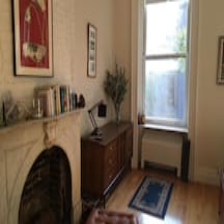

[[[0.68235296 0.5764706  0.40784314]
  [0.6745098  0.5686275  0.4       ]
  [0.6745098  0.54901963 0.3882353 ]
  ...
  [0.5647059  0.49019608 0.3647059 ]
  [0.5647059  0.49019608 0.3647059 ]
  [0.5647059  0.49019608 0.3647059 ]]

 [[0.68235296 0.5764706  0.40784314]
  [0.6745098  0.5686275  0.4       ]
  [0.6745098  0.5529412  0.39215687]
  ...
  [0.5647059  0.49019608 0.3647059 ]
  [0.5647059  0.49019608 0.3647059 ]
  [0.5647059  0.49019608 0.3647059 ]]

 [[0.68235296 0.5764706  0.40784314]
  [0.6745098  0.5686275  0.4       ]
  [0.6784314  0.5529412  0.39215687]
  ...
  [0.5647059  0.49019608 0.3647059 ]
  [0.5647059  0.49019608 0.3647059 ]
  [0.5647059  0.49019608 0.3647059 ]]

 ...

 [[0.44705883 0.36862746 0.2627451 ]
  [0.43529412 0.35686275 0.2509804 ]
  [0.4392157  0.36078432 0.25490198]
  ...
  [0.2901961  0.19607843 0.14509805]
  [0.30980393 0.19215687 0.15294118]
  [0.30980393 0.18431373 0.14901961]]

 [[0.44313726 0.3647059  0.25882354]
  [0.43529412 0.35686275 0.2509804 ]


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
cv2_imshow(rgb_muestra*255)
print(images[muestra_i])

## Carga de datos
Después de haber descargado los datasets, empezamos el tratamiento de los datos.

Por tema de tiempo disponible para la resolución del problema, se planteará el desarrollo de manera categórica.

Empezamos importando las librerias que se utilizarán a lo largo del desarrollo del notebook y con celdas preparativas como fijar la semilla para intentar tener repetibilidad en las pruebas.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG16

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils



In [ ]:
inputPath = "/content/drive/MyDrive/PERSONAL/Educación/Deep_Learning-Keepcoding/"

data = pd.read_csv(inputPath+"/data_KC.csv", sep=';')
images = np.load(inputPath+"/images_KC.npy")
data.shape, images.shape

((2138, 30), (2138, 224, 224, 3))

In [ ]:
#Se fija la semilla para el desarrollo del notebook
seed = 33
np.random.seed(seed = 33)
keras.utils.set_random_seed(seed = 33)
pd.set_option('display.max_rows', None)

Hacemos un poco de exploración de datos

In [ ]:
#Observamos la estructura de los datos tabulares
data.head(5).T

,0,1,2,3,4
id,6901257,6304928,13418779,12422935,11825529
log_price,5.010635,5.129899,6.620073,4.442651,4.418841
property_type,Apartment,Apartment,House,Apartment,Apartment
room_type,Entire home/apt,Entire home/apt,Entire home/apt,Private room,Entire home/apt
amenities,"{""Wireless Internet"",""Air conditioning"",Kitche...","{""Wireless Internet"",""Air conditioning"",Kitche...","{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...","{TV,""Wireless Internet"",Heating,""Smoke detecto...","{TV,Internet,""Wireless Internet"",""Air conditio..."
accommodates,3,7,4,2,3
bathrooms,1.0,1.0,1.0,1.0,1.0
bed_type,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed
cancellation_policy,strict,strict,flexible,strict,moderate
cleaning_fee,True,True,True,True,True


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2138.0,1.136124e+07,6.178428e+06,12068.000000,6.093602e+06,1.283173e+07,1.650302e+07,2.118810e+07
log_price,2138.0,4.761809e+00,6.926899e-01,2.890372,4.317488e+00,4.691348e+00,5.164786e+00,7.467371e+00
accommodates,2138.0,3.021983e+00,2.028571e+00,1.000000,2.000000e+00,2.000000e+00,4.000000e+00,1.600000e+01
bathrooms,2131.0,1.192163e+00,4.799057e-01,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,5.500000e+00
latitude,2138.0,3.865561e+01,2.968383e+00,33.343574,3.419030e+01,4.067724e+01,4.074173e+01,4.238387e+01
longitude,2138.0,-9.127346e+01,2.175370e+01,-122.508663,-1.183435e+02,-7.400107e+01,-7.395095e+01,-7.099186e+01
number_of_reviews,2138.0,1.932928e+01,3.539529e+01,0.000000,1.000000e+00,5.000000e+00,2.175000e+01,3.180000e+02
review_scores_rating,1590.0,9.391824e+01,9.227063e+00,20.000000,9.200000e+01,9.600000e+01,1.000000e+02,1.000000e+02
bedrooms,2134.0,1.210872e+00,7.881886e-01,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,7.000000e+00
beds,2135.0,1.637471e+00,1.151870e+00,1.000000,1.000000e+00,1.000000e+00,2.000000e+00,1.600000e+01


Como el problema se resolverá de forma categórica, la variable 'Price' se sutituirá en tres (3) rangos: Bajo, medio y alto.

In [ ]:
def price_to_categorical(data, limits):
  y_class = []
  for y in data['Price']:
    if y <= limits[0]:
      y_class.append(0) # Precio bajo
    elif limits[0] < y <= limits[1]:
      y_class.append(1) # Precio medio
    else:
      y_class.append(2) # Precio alto
  y_class = pd.Series(y_class)
  y_class.hist(bins=3)
  data["Price_categorical"] = y_class
  return data

Para escoger los limites para la categorización del precio, se calcula el valor medio entre el 25%-50% y entre el 50%-75%, según lo observado en el data.describe()

,0,1,2,3,4
id,6901257,6304928,13418779,12422935,11825529
log_price,5.010635,5.129899,6.620073,4.442651,4.418841
property_type,Apartment,Apartment,House,Apartment,Apartment
room_type,Entire home/apt,Entire home/apt,Entire home/apt,Private room,Entire home/apt
amenities,"{""Wireless Internet"",""Air conditioning"",Kitche...","{""Wireless Internet"",""Air conditioning"",Kitche...","{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...","{TV,""Wireless Internet"",Heating,""Smoke detecto...","{TV,Internet,""Wireless Internet"",""Air conditio..."
accommodates,3,7,4,2,3
bathrooms,1.0,1.0,1.0,1.0,1.0
bed_type,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed
cancellation_policy,strict,strict,flexible,strict,moderate
cleaning_fee,True,True,True,True,True


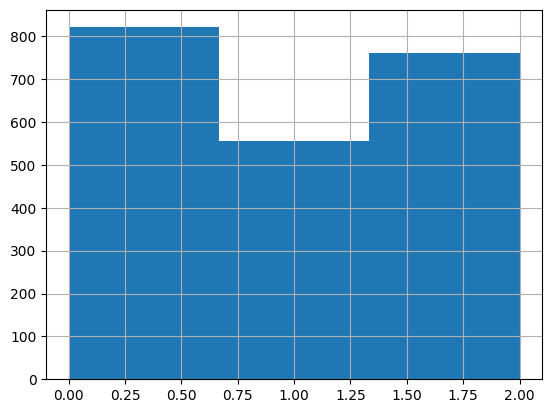

In [ ]:
data = price_to_categorical(data,limits = [92,142])
data.head(5).T

In [ ]:
#Eliminamos la columna del Price
data = data.drop('Price', axis =1)
data.head(5).T

,0,1,2,3,4
id,6901257,6304928,13418779,12422935,11825529
log_price,5.010635,5.129899,6.620073,4.442651,4.418841
property_type,Apartment,Apartment,House,Apartment,Apartment
room_type,Entire home/apt,Entire home/apt,Entire home/apt,Private room,Entire home/apt
amenities,"{""Wireless Internet"",""Air conditioning"",Kitche...","{""Wireless Internet"",""Air conditioning"",Kitche...","{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...","{TV,""Wireless Internet"",Heating,""Smoke detecto...","{TV,Internet,""Wireless Internet"",""Air conditio..."
accommodates,3,7,4,2,3
bathrooms,1.0,1.0,1.0,1.0,1.0
bed_type,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed
cancellation_policy,strict,strict,flexible,strict,moderate
cleaning_fee,True,True,True,True,True


## Creación de particiones
Llegados a este punto, ya se puede dividir en train, validación y test.

In [ ]:
from sklearn.model_selection import train_test_split

#Separamos los atributos de la variable target ('Price_categorical')
x_data = data.drop('Price_categorical', axis = 1)
y_data = data['Price_categorical']

In [ ]:
#División train y test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=seed,
                                                        shuffle=True, stratify=y_data)
#División train y validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=seed,
                                                  shuffle=True, stratify=y_train)

In [ ]:
#Imprimimos las dimensiones de los datos
print(f'Dimensiones del dataset de training: {x_train.shape,y_train.shape}')
print(f'Dimensiones del dataset de validation: {x_val.shape,y_val.shape}')
print(f'Dimensiones del dataset de test: {x_test.shape,y_test.shape}')

Dimensiones del dataset de training: ((1368, 29), (1368,))
Dimensiones del dataset de validation: ((342, 29), (342,))
Dimensiones del dataset de test: ((428, 29), (428,))


In [ ]:
#Guardamos los datasets en archivos independientes

x_train.to_csv(inputPath + "/x_train.csv", sep=';', decimal='.', index=False)
x_val.to_csv(inputPath + "/x_val.csv", sep=';', decimal='.', index=False)
x_test.to_csv(inputPath + "/x_test.csv", sep=';', decimal='.', index=False)

y_train.to_csv(inputPath + "/y_train.csv", sep=';', decimal='.', index=False)
y_val.to_csv(inputPath + "/y_val.csv", sep=';', decimal='.', index=False)
y_test.to_csv(inputPath + "/y_test.csv", sep=';', decimal='.', index=False)


In [ ]:
#Se tiene como 'checkpoint' esta celda para cargar los datos desde este punto si se desconecta la consola
#poder cargar exactamente los mismos datos, sin necesidad de ejecutar el resto de celdas.

#Descomentar líneas de código de abajo

x_train = pd.read_csv(inputPath+ "/x_train.csv", sep=';', decimal='.')
x_val = pd.read_csv(inputPath+ "/x_val.csv", sep=';', decimal='.')
x_test = pd.read_csv(inputPath+ "/x_test.csv", sep=';', decimal='.')

y_train = pd.read_csv(inputPath+ "/y_train.csv", sep=';', decimal='.')
y_val = pd.read_csv(inputPath+ "/y_val.csv", sep=';', decimal='.')
y_test = pd.read_csv(inputPath+ "/y_test.csv", sep=';', decimal='.')


In [ ]:
  #Convertimos los valores codificados a one-hot encoding
  y_train = to_categorical(y_train)
  y_val = to_categorical(y_val)
  y_test = to_categorical(y_test)
  # Convertimos a df:
  y_train = pd.DataFrame(y_train, columns=["bajo","medio", "alto"])
  y_train.index = y_train.index.values
  y_val = pd.DataFrame(y_val, columns=["bajo","medio", "alto"])
  y_val.index = y_val.index.values
  y_test = pd.DataFrame(y_test, columns=["bajo","medio", "alto"])
  y_test.index = y_test.index.values

In [ ]:
#Verificamos que se haya efectuado la categorización correctamente
y_train.head()

,bajo,medio,alto
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0


## Tratamiento de los datos
Una vez categorizada la variable objetivo a predecir 'Price_categorical', nos centraremos en el siguiente apartado en los atributos (cómo tratar los nulos, escalados para que los modelos funcionen mejor, etc) para prepararlos de cara a la Red MLP.

In [ ]:
#Volvemos a visualizar los atributos
x_train.head().T

,0,1,2,3,4
id,593253,1243883,6089007,14823526,9139920
log_price,5.697093,4.553877,4.382027,5.616771,4.077537
property_type,Apartment,Apartment,Apartment,Apartment,Apartment
room_type,Entire home/apt,Private room,Private room,Entire home/apt,Private room
amenities,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...","{TV,Internet,""Wireless Internet"",Kitchen,Gym,""...","{TV,""Wireless Internet"",Kitchen,Elevator,Heati...","{TV,""Cable TV"",Internet,""Wireless Internet"",""A...","{TV,""Cable TV"",""Wireless Internet"",""Air condit..."
accommodates,8,2,1,4,2
bathrooms,3.0,1.5,1.0,1.5,1.0
bed_type,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed
cancellation_policy,strict,strict,flexible,moderate,moderate
cleaning_fee,True,False,True,True,True


In [ ]:
#Visualizamos los tipos de los atributos
x_train.dtypes

id                          int64
log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
description                object
first_review               object
host_has_profile_pic       object
host_identity_verified     object
host_response_rate         object
host_since                 object
instant_bookable           object
last_review                object
latitude                  float64
longitude                 float64
name                       object
neighbourhood              object
number_of_reviews           int64
review_scores_rating      float64
thumbnail_url              object
zipcode                    object
bedrooms                  float64
beds                      float64
dtype: object

In [ ]:
#Visualizamos si tienen nulos y cuántos de ellos lo son
#x_train.isnull().any()
print('Total: ',len(x_train))
len(x_train)-x_train.count()

Total:  1368


id                          0
log_price                   0
property_type               0
room_type                   0
amenities                   0
accommodates                0
bathrooms                   6
bed_type                    0
cancellation_policy         0
cleaning_fee                0
city                        0
description                 0
first_review              331
host_has_profile_pic        6
host_identity_verified      6
host_response_rate        406
host_since                  6
instant_bookable            0
last_review               329
latitude                    0
longitude                   0
name                        0
neighbourhood             105
number_of_reviews           0
review_scores_rating      345
thumbnail_url               0
zipcode                    18
bedrooms                    4
beds                        3
dtype: int64

In [ ]:
#Para evitar perder muchas muestras, ya que se cuentan con pocas para el ejercicio,
#y con la idea de simplificar, se van a rellenar los valores nulos con la moda y mediana.
cols_mode = ['first_review','last_review','neighbourhood','zipcode',
             'host_has_profile_pic','host_identity_verified','property_type',
             'host_since','host_response_rate']
cols_mean = ['bathrooms','latitude','longitude','review_scores_rating',
             'bedrooms','beds']
for col in cols_mode:
  x_train[col] = x_train[col].fillna(x_train[col].mode()[0])

for col in cols_mean:
  x_train[col] = x_train[col].fillna(x_train[col].mean())


In [ ]:
#Se aprovecha de rellenar los nulos para validation y test.
#Para ello se utilizan los mismos valores del train!

for col in cols_mode:
  x_val[col] = x_val[col].fillna(x_train[col].mode()[0])
  x_test[col] = x_test[col].fillna(x_train[col].mode()[0])

for col in cols_mean:
  x_val[col] = x_val[col].fillna(x_train[col].mean())
  x_test[col] = x_test[col].fillna(x_train[col].mean())

In [ ]:
#Verificamos no nulos en validation ni en test
len(x_val)-x_val.count()
#len(x_test)-x_test.count()

id                        0
log_price                 0
property_type             0
room_type                 0
amenities                 0
accommodates              0
bathrooms                 0
bed_type                  0
cancellation_policy       0
cleaning_fee              0
city                      0
description               0
first_review              0
host_has_profile_pic      0
host_identity_verified    0
host_response_rate        0
host_since                0
instant_bookable          0
last_review               0
latitude                  0
longitude                 0
name                      0
neighbourhood             0
number_of_reviews         0
review_scores_rating      0
thumbnail_url             0
zipcode                   0
bedrooms                  0
beds                      0
dtype: int64

Con todos los datos rellenados, se procede a:
1. Eliminar algunos atributos que no aportan valor o no aplican al estudio, por ejemplo: ID, log_price.
2. Transformar atributos descriptivos a numéricos, por ejemplo: amenities (se cuenta el total de amenities y se trabaja con ese valor), description (se cuenta la cantidad de palabras), etc. -Esto se hace por simplificar el tratamiento de las variables y por no ser capaces de procesar/interpretar el texto hasta estos momentos.
3. Normalizar los valores numéricos para un mejor funcionamiento de las redes.

Por optimizar espacio, se aprovecha de hacer el tratamiento para los 3 datsets. En condiciones normales, se haría primero todo el procesamiento con los datos de train y, a continuación, se replicaría para los otros.

In [ ]:
#Eliminamos atributos
cols_drop_na = ['id','log_price','thumbnail_url','zipcode'] #se decide eliminar zipcode por simplificar, teniendo las coordenadas que aportan valor similar.
x_train = x_train.drop(cols_drop_na, axis = 1)
x_val = x_val.drop(cols_drop_na, axis = 1)
x_test = x_test.drop(cols_drop_na, axis = 1)

In [ ]:
#Definición de funciones para conversión de atributos
def contar_elementos(texto, sep = ','): #función que permite contar elementos en un campo de texto
    return len(texto.split(sep))

In [ ]:
#Transformamos atributos descriptivos a numéricos
x_train['amenities'] = x_train['amenities'].apply(contar_elementos)
x_val['amenities'] = x_val['amenities'].apply(contar_elementos)
x_test['amenities'] = x_test['amenities'].apply(contar_elementos)

x_train['description'] = x_train['description'].apply(contar_elementos, sep = ' ')
x_val['description'] = x_val['description'].apply(contar_elementos, sep = ' ')
x_test['description'] = x_test['description'].apply(contar_elementos, sep = ' ')

x_train['name'] = x_train['name'].apply(contar_elementos, sep = ' ')
x_val['name'] = x_val['name'].apply(contar_elementos, sep = ' ')
x_test['name'] = x_test['name'].apply(contar_elementos, sep = ' ')

In [ ]:
#Analizamos para convertir atributos a booleanos
x_train['host_has_profile_pic'].value_counts()

host_has_profile_pic
t    1363
f       5
Name: count, dtype: int64

In [ ]:
x_train['host_identity_verified'].value_counts()

host_identity_verified
t    890
f    478
Name: count, dtype: int64

In [ ]:
x_train['instant_bookable'].value_counts()

instant_bookable
f    1009
t     359
Name: count, dtype: int64

In [ ]:
#Convertimos a booleanos
x_train['host_has_profile_pic'] = x_train['host_has_profile_pic'].replace({'t':True,'f':False})*1.0
x_train['host_identity_verified'] = x_train['host_identity_verified'].replace({'t':True,'f':False})*1.0
x_train['instant_bookable'] = x_train['instant_bookable'].replace({'t':True,'f':False})*1.0
x_train['cleaning_fee'] = x_train['cleaning_fee']*1.0

x_val['host_has_profile_pic'] = x_val['host_has_profile_pic'].replace({'t':True,'f':False})*1.0
x_val['host_identity_verified'] = x_val['host_identity_verified'].replace({'t':True,'f':False})*1.0
x_val['instant_bookable'] = x_val['instant_bookable'].replace({'t':True,'f':False})*1.0
x_val['cleaning_fee'] = x_val['cleaning_fee']*1.0

x_test['host_has_profile_pic'] = x_test['host_has_profile_pic'].replace({'t':True,'f':False})*1.0
x_test['host_identity_verified'] = x_test['host_identity_verified'].replace({'t':True,'f':False})*1.0
x_test['instant_bookable'] = x_test['instant_bookable'].replace({'t':True,'f':False})*1.0
x_test['cleaning_fee'] = x_test['cleaning_fee']*1.0

In [ ]:
#Convertimos atributo porcentual a float
x_train['host_response_rate'] = x_train['host_response_rate'].str.rstrip('%').astype(float)
x_val['host_response_rate'] = x_val['host_response_rate'].str.rstrip('%').astype(float)
x_test['host_response_rate'] = x_test['host_response_rate'].str.rstrip('%').astype(float)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

cols_num = cols_mean +['amenities','description','name','accommodates','host_response_rate','number_of_reviews']

#Normalizamos los datos numéricos
for col in cols_num:
  mm_scaler = MinMaxScaler()
  scaled_col_train = mm_scaler.fit_transform(x_train[col].values.reshape(-1,1))
  scaled_col_val = mm_scaler.transform(x_val[col].values.reshape(-1,1))
  scaled_col_test = mm_scaler.transform(x_test[col].values.reshape(-1,1))

  x_train[col] = scaled_col_train
  x_val[col] = scaled_col_val
  x_test[col] = scaled_col_test

In [ ]:
#Selección de columnas categóricas
cols_categoricos = ['neighbourhood','cancellation_policy','bed_type',
                    'room_type','property_type']

#Se transforman los atributos categóricos con one-hot encoding como se ha visto en clase
data_categorical = pd.DataFrame([], columns=[])
for col in cols_categoricos:
  new_cols_oneHot = pd.get_dummies(data[col], prefix=col)*1.0
  data_categorical = pd.concat([data_categorical, new_cols_oneHot], axis=1)

#Sustituimos columnas categóricas por las nuevas creadas.
x_train = x_train.join(data_categorical.iloc[y_train.index.values])
x_val = x_val.join(data_categorical.iloc[y_val.index.values])
x_test = x_test.join(data_categorical.iloc[y_test.index.values])

x_train = x_train.drop(cols_categoricos, axis=1)
x_val = x_val.drop(cols_categoricos, axis=1)
x_test = x_test.drop(cols_categoricos, axis=1)

In [ ]:
#Quitamos las fechas
cols_drop_dates = ['first_review','host_since','last_review','city']

x_train = x_train.drop(cols_drop_dates, axis = 1)
x_val = x_val.drop(cols_drop_dates, axis = 1)
x_test = x_test.drop(cols_drop_dates, axis = 1)

In [24]:
#Observamos los datos después de las modificaciones
x_train.head(5).T

,0,1,2,3,4
amenities,0.428571,0.339286,0.232143,0.339286,0.357143
accommodates,0.466667,0.066667,0.000000,0.200000,0.066667
bathrooms,0.545455,0.272727,0.181818,0.272727,0.181818
cleaning_fee,1.000000,0.000000,1.000000,1.000000,1.000000
description,0.748815,0.881517,0.611374,0.156398,0.829384
host_has_profile_pic,1.000000,1.000000,1.000000,1.000000,1.000000
host_identity_verified,1.000000,1.000000,1.000000,1.000000,1.000000
host_response_rate,1.000000,0.670000,1.000000,1.000000,1.000000
instant_bookable,1.000000,0.000000,1.000000,0.000000,0.000000
latitude,0.083864,0.817040,0.824771,0.995708,0.989400


In [23]:
#Guardamos los datasets en archivos independientes

x_train.to_csv(inputPath + "/x_train_rdy.csv", sep=';', decimal='.', index=False)
x_val.to_csv(inputPath + "/x_val_rdy.csv", sep=';', decimal='.', index=False)
x_test.to_csv(inputPath + "/x_test_rdy.csv", sep=';', decimal='.', index=False)

------------------------------------------------------------------------------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG16

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils

In [3]:
inputPath = "/content/drive/MyDrive/PERSONAL/Educación/Deep_Learning-Keepcoding/"

In [25]:
#Se tiene como segundo 'checkpoint' esta celda para cargar los datos desde este punto si se desconecta la consola
#poder cargar exactamente los mismos datos, sin necesidad de ejecutar el resto de celdas.

x_train = pd.read_csv(inputPath+ "/x_train_rdy.csv", sep=';', decimal='.')
x_val = pd.read_csv(inputPath+ "/x_val_rdy.csv", sep=';', decimal='.')
x_test = pd.read_csv(inputPath+ "/x_test_rdy.csv", sep=';', decimal='.')

y_train = pd.read_csv(inputPath+ "/y_train.csv", sep=';', decimal='.')
y_val = pd.read_csv(inputPath+ "/y_val.csv", sep=';', decimal='.')
y_test = pd.read_csv(inputPath+ "/y_test.csv", sep=';', decimal='.')

In [26]:
x_train.head().T

,0,1,2,3,4
amenities,0.428571,0.339286,0.232143,0.339286,0.357143
accommodates,0.466667,0.066667,0.000000,0.200000,0.066667
bathrooms,0.545455,0.272727,0.181818,0.272727,0.181818
cleaning_fee,1.000000,0.000000,1.000000,1.000000,1.000000
description,0.748815,0.881517,0.611374,0.156398,0.829384
host_has_profile_pic,1.000000,1.000000,1.000000,1.000000,1.000000
host_identity_verified,1.000000,1.000000,1.000000,1.000000,1.000000
host_response_rate,1.000000,0.670000,1.000000,1.000000,1.000000
instant_bookable,1.000000,0.000000,1.000000,0.000000,0.000000
latitude,0.083864,0.817040,0.824771,0.995708,0.989400


In [27]:
#Se fija la semilla para el desarrollo del notebook
seed = 33
np.random.seed(seed = 33)
keras.utils.set_random_seed(seed = 33)
pd.set_option('display.max_rows', None)

## Red 1D Multi Layer Perceptron
Llegados a este punto, los atributos están preparados para ser introducidos a una red MLP para su procesamiento.

In [15]:
(x_train.shape,y_train.shape)

((1368, 389), (1368, 1))

In [28]:
x_train.dtypes

amenities                                         float64
accommodates                                      float64
bathrooms                                         float64
cleaning_fee                                      float64
description                                       float64
host_has_profile_pic                              float64
host_identity_verified                            float64
host_response_rate                                float64
instant_bookable                                  float64
latitude                                          float64
longitude                                         float64
name                                              float64
number_of_reviews                                 float64
review_scores_rating                              float64
bedrooms                                          float64
beds                                              float64
neighbourhood_16th Street Heights                 float64
neighbourhood_

In [37]:
from sklearn.metrics import classification_report

y_train_categorical = keras.utils.to_categorical(y_train, num_classes=3)
y_val_categorical = keras.utils.to_categorical(y_val, num_classes=3)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes=3)

n_epochs = 50
batch_size = 128
learning_rate = 0.01
n_classes = 3

input_shape = x_train.shape[-1]

model1D = Sequential()
model1D.add(Dense(128, input_shape=(input_shape,), activation="relu"))
model1D.add(Dense(128, activation="relu"))
model1D.add(Dense(n_classes, activation="softmax"))
model1D.summary()


model1D.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate), metrics=["accuracy"])
H = model1D.fit(x_train, y_train_categorical, validation_data=(x_val, y_val_categorical), epochs=n_epochs, batch_size=batch_size)

predictions1D_train = model1D.predict(x_train, batch_size=batch_size)
predictions1D_val = model1D.predict(x_val, batch_size=batch_size)
predictions1D_test = model1D.predict(x_test, batch_size=batch_size)
print(classification_report(y_test.values.argmax(axis=1), predictions1D_test.argmax(axis=1)))


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 128)               49792     
                                                                 
 dense_46 (Dense)            (None, 128)               16512     
                                                                 
 dense_47 (Dense)            (None, 3)                 387       
                                                                 
Total params: 66691 (260.51 KB)
Trainable params: 66691 (260.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
11/11 [==============================] - 2s 72ms/step - loss: 1.1006 - accuracy: 0.3553 - val_loss: 1.1026 - val_accuracy: 0.3333
Epoch 2/50
11/11 [==============================] - 0s 21ms/step - loss: 1.0960 - accuracy: 0.3596 - val_loss: 1.0994 - val_accuracy: 0.36

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Carga de imágenes
En este punto se recupera la carga de las imágenes. Para ello, usamos la función load de la librería numpy.

In [6]:
images = np.load(inputPath+"/images_KC.npy")
images.shape

(2138, 224, 224, 3)

Como se pudo observar en el momento de cargar las imágenes, las matrices de los datos ya vienen normalizadas, con valores entre 0-1.

In [7]:
train_x_imgs = images[y_train.index.values, :,:,:]
val_x_imgs = images[y_val.index.values, :,:,:]
test_x_imgs = images[y_test.index.values, :,:,:]
# Imágenes:
(train_x_imgs.shape, val_x_imgs.shape, test_x_imgs.shape)

((1368, 224, 224, 3), (342, 224, 224, 3), (428, 224, 224, 3))

### Red 2D convolucional
Es un tipo de red donde las neuronas artificiales, corresponden a campos receptivos de una manera muy similar a las neuronas en la corteza visual primaria (V1) de un cerebro biológico, por este motivo, se utiliza para problemas a resolver con imágenes.

In [8]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# Inizializamos el modelo
model2D = Sequential()

# Definimos una capa convolucional
model2D.add(Conv2D(32, kernel_size=(7, 7), activation='relu', input_shape=(224, 224, 3)))

# Definimos una segunda capa convolucional
model2D.add(Conv2D(64, kernel_size=(7, 7), activation='relu'))

# Añadimos nuestro clasificador
model2D.add(GlobalMaxPooling2D())
model2D.add(Dense(128, activation='relu'))
model2D.add(Dense(3, activation='softmax'))

# Compilamos el modelo
model2D.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])

# Entrenamos el modelo
model2D.fit(train_x_imgs, to_categorical(y_train),
          batch_size=12,
          shuffle=True,
          epochs=10,
          validation_data=(val_x_imgs, to_categorical(y_val)))

# Evaluamos el modelo
scores = model2D.evaluate(test_x_imgs, to_categorical(y_test))

print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

Epoch 1/10
114/114 [==============================] - 17s 79ms/step - loss: 1.2647 - accuracy: 0.3713 - val_loss: 1.0863 - val_accuracy: 0.3567
Epoch 2/10
114/114 [==============================] - 8s 66ms/step - loss: 1.0884 - accuracy: 0.3684 - val_loss: 1.0860 - val_accuracy: 0.3830
Epoch 3/10
114/114 [==============================] - 8s 69ms/step - loss: 1.0888 - accuracy: 0.3728 - val_loss: 1.0861 - val_accuracy: 0.3830
Epoch 4/10
114/114 [==============================] - 8s 68ms/step - loss: 1.0888 - accuracy: 0.3604 - val_loss: 1.0862 - val_accuracy: 0.3830
Epoch 5/10
114/114 [==============================] - 8s 69ms/step - loss: 1.0887 - accuracy: 0.3721 - val_loss: 1.0864 - val_accuracy: 0.3830
Epoch 6/10
114/114 [==============================] - 8s 70ms/step - loss: 1.0880 - accuracy: 0.3684 - val_loss: 1.0873 - val_accuracy: 0.3830
Epoch 7/10
114/114 [==============================] - 8s 68ms/step - loss: 1.0882 - accuracy: 0.3706 - val_loss: 1.0861 - val_accuracy: 0.383

Ahora aplicamos un ejemplo usando Maxnorm y MaxPooling, dos técnicas que permiten regularizar. El primero de ellos, es restringiendo el máximo valor de los pesos (w) -se suele usar entre 3 y 4-. El segundo de ellos, MaxPooling, nos permite reducir considerablemente el número de parámetros si se compara con la capa Flatten, pudiendo perder accuracy.

In [13]:
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import MaxPooling2D

batch_size = 64

# Inizializamos el modelo
model = Sequential()

# Definimos una capa convolucional
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))

# Definimos una segunda capa convolucional
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Definimos una tercera capa convolucional
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Añadimos nuestro clasificador
#model.add(Flatten())
model.add(GlobalMaxPooling2D())
model.add(Dense(128, activation='relu', kernel_constraint=max_norm(4.)))
model.add(Dense(3, activation='softmax'))


# Compilamos el modelo
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.001,
      decay_steps=100,
      decay_rate=0.96,
      staircase=True)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr_schedule),
              metrics=['accuracy'])

# Entrenamos el modelo
H = model.fit(train_x_imgs, to_categorical(y_train),
          batch_size=batch_size,
          shuffle=True,
          epochs=10,
          validation_data=(val_x_imgs, to_categorical(y_val)))

predictions2D_train = model2D.predict(train_x_imgs, batch_size=batch_size)
predictions2D_val = model2D.predict(val_x_imgs, batch_size=batch_size)
predictions2D_test = model2D.predict(test_x_imgs, batch_size=batch_size)

# Evaluamos el modelo
scores = model.evaluate(test_x_imgs, to_categorical(y_test))

print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

Epoch 1/10
22/22 [==============================] - 9s 304ms/step - loss: 1.0918 - accuracy: 0.3611 - val_loss: 1.0855 - val_accuracy: 0.3684
Epoch 2/10
22/22 [==============================] - 6s 287ms/step - loss: 1.0867 - accuracy: 0.3889 - val_loss: 1.0853 - val_accuracy: 0.3830
Epoch 3/10
22/22 [==============================] - 6s 288ms/step - loss: 1.0867 - accuracy: 0.3838 - val_loss: 1.0859 - val_accuracy: 0.3830
Epoch 4/10
22/22 [==============================] - 6s 280ms/step - loss: 1.0865 - accuracy: 0.3838 - val_loss: 1.0859 - val_accuracy: 0.3830
Epoch 5/10
22/22 [==============================] - 6s 295ms/step - loss: 1.0885 - accuracy: 0.3640 - val_loss: 1.0850 - val_accuracy: 0.3830
Epoch 6/10
22/22 [==============================] - 6s 285ms/step - loss: 1.0874 - accuracy: 0.3838 - val_loss: 1.0854 - val_accuracy: 0.3830
Epoch 7/10
22/22 [==============================] - 6s 281ms/step - loss: 1.0871 - accuracy: 0.3838 - val_loss: 1.0858 - val_accuracy: 0.3801
Epoch 

[]

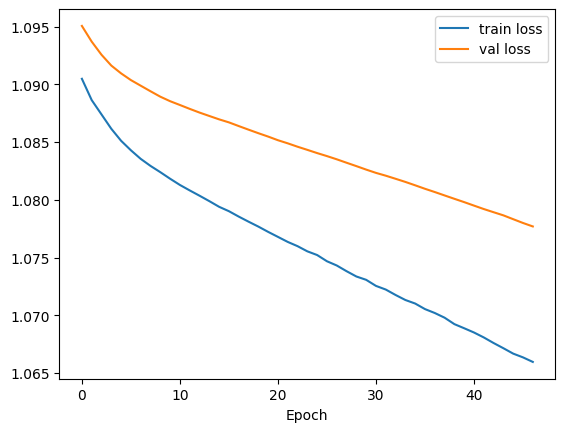

In [38]:
import matplotlib.pyplot as plt

plt.plot(H.history['loss'][3::], label='train loss') # Si vemos que sale como un pico enorme, nos quitamos los primeros valores para ver al evolución en el resto de casos
plt.plot(H.history['val_loss'][3::], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.plot()

Aunque parece que no está estabilizado el valor de la Loss con respecto a las Epoch, la variación que está teniendo es muy baja. Se puede ampiar la cantidad de Epochs para comprobarlo.

Sería interesante aplicar alguna red pre-entrenada y valorar si se generan mejores resultados. Queda pendiente para trabajos posteriores.

### Late Fusion
Ahora se fusiona la salida de cada una de las redes (model1D y model2D) para pasarlo a un nuevo modelo. En este caso se utilizará un SVM.

In [39]:
# Se concatenan las salidas de ambos modelos en una misma estructura df
lf_train = np.concatenate((predictions1D_train, predictions2D_train), axis=1)
lf_val = np.concatenate((predictions1D_val, predictions2D_val), axis=1)
lf_test = np.concatenate((predictions1D_test, predictions2D_test), axis=1)
print(lf_train.shape)
print(lf_val.shape)
print(lf_test.shape)

(1368, 6)
(342, 6)
(428, 6)


In [50]:
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, r2_score

model_lf = svm.SVC()

y_train_new = y_train
y_val_new = y_val
y_test_new = y_test

model_lf.fit(lf_train, y_train_new)

y_pred_train = model_lf.predict(lf_train)
y_pred_val = model_lf.predict(lf_val)
y_pred_test = model_lf.predict(lf_test)

cm = confusion_matrix(y_test_new, y_pred_test)
print(cm)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[129   0  36]
 [ 72   0  39]
 [ 91   0  61]]


###Early Fusion
En este caso, se fusionan los datos antes de incorporarlos a una red. Los tabulares, por un lado, y por el otro las imágenes previamente acondicionadas para que sea compatible introducirlas en un modelo junto a los tabulares.

In [51]:
from tensorflow.keras import optimizers, Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

#Se utiliza para el clasificador de las imágenes una red pre-entrenada en este caso.
classifier2D = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
last_conv = classifier2D.layers[-1].output
last_conv_globalAvg = GlobalAveragePooling2D()(last_conv)
feature_extractor = Model(classifier2D.input, last_conv_globalAvg)

#Se procesan los datos de las imágenes para que sea compatible posteiormente
ef_train_imgs = feature_extractor.predict(train_x_imgs)
ef_val_imgs = feature_extractor.predict(val_x_imgs)
ef_test_imgs = feature_extractor.predict(test_x_imgs)

# Se concatenan las salidas de ambos modelos en una misma estructura df
ef_train = np.concatenate((x_train, ef_train_imgs), axis=1)
ef_val = np.concatenate((x_val, ef_val_imgs), axis=1)
ef_test = np.concatenate((x_test, ef_test_imgs), axis=1)
print(ef_train.shape)
print(ef_val.shape)
print(ef_test.shape)

14/14 [==============================] - 5s 383ms/step
(1368, 900)
(342, 900)
(428, 900)


In [52]:
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, r2_score

model_ef = svm.SVC()
model_ef.fit(ef_train, y_train_new)

y_pred_train = model_ef.predict(ef_train)
y_pred_val = model_ef.predict(ef_val)
y_pred_test = model_ef.predict(ef_test)

cm = confusion_matrix(y_test_new, y_pred_test)
print(cm)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[163   0   2]
 [106   0   5]
 [128   0  24]]


Vamos a probar el Early Fusion con una MLP para ver el comportamiento del accuracy.

In [53]:
from sklearn.metrics import classification_report

y_train_categorical = keras.utils.to_categorical(y_train, num_classes=3)
y_val_categorical = keras.utils.to_categorical(y_val, num_classes=3)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes=3)

n_epochs = 50
batch_size = 128
learning_rate = 0.01
n_classes = 3

input_shape = ef_train.shape[-1]

model_ef = Sequential()
model_ef.add(Dense(128, input_shape=(input_shape,), activation="relu"))
model_ef.add(Dense(128, activation="relu"))
model_ef.add(Dense(n_classes, activation="softmax"))
model_ef.summary()


model_ef.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate), metrics=["accuracy"])
H = model_ef.fit(ef_train, y_train_categorical, validation_data=(ef_val, y_val_categorical), epochs=n_epochs, batch_size=batch_size)

predictions_ef_train = model_ef.predict(ef_train, batch_size=batch_size)
predictions_ef_val = model_ef.predict(ef_val, batch_size=batch_size)
predictions_ef_test = model_ef.predict(ef_test, batch_size=batch_size)
print(classification_report(y_test.values.argmax(axis=1), predictions_ef_test.argmax(axis=1)))

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 128)               115328    
                                                                 
 dense_49 (Dense)            (None, 128)               16512     
                                                                 
 dense_50 (Dense)            (None, 3)                 387       
                                                                 
Total params: 132227 (516.51 KB)
Trainable params: 132227 (516.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
11/11 [==============================] - 1s 21ms/step - loss: 1.1017 - accuracy: 0.3713 - val_loss: 1.0819 - val_accuracy: 0.4240
Epoch 2/50
11/11 [==============================] - 0s 7ms/step - loss: 1.0863 - accuracy: 0.3867 - val_loss: 1.0806 - val_accuracy: 0.4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
